Yes, that is a common issue with z-score normalization, where the resulting scaled values can be negative if the original data has a mean greater than zero. This is because z-score normalization centers the data around its mean, which can result in negative values for data points that are below the mean.

If negative values are not desirable in your analysis, you can consider using a modified version of z-score normalization called the "scaled" z-score, which scales the data by the median absolute deviation (MAD) instead of the standard deviation. This technique is also known as the "robust z-score" and can be useful for data that has a high degree of skewness or outliers.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler

## Load data

For time series data, min-max scaling may not always be the best choice of normalization, as it assumes a linear relationship between the values and can be sensitive to outliers. There are other normalization techniques that may be more appropriate for time series data.

In [4]:
# Load data:
filename = "gams_indoor.csv"

data = pd.read_csv(
    filename,
    parse_dates=["ts"],
    index_col=["ts"],

        )
cols_to_scale = data.columns[:]

# Create a scaler object and fit it on the data
scaler = MinMaxScaler()
scaler.fit(data[cols_to_scale])

# Transform the data and replace the original columns in-place
data[cols_to_scale] = scaler.transform(data[cols_to_scale])
    # Load data: only the time variable and CO.

data = data.resample('H').mean()
# Sanity: sort index.
data.sort_index(inplace=True)
data.head()

,co2,humidity,pm10,pm25,temperature,voc
ts,,,,,,
2016-11-21 00:00:00,0.143928,0.925410,0.056407,0.087367,0.392345,0.000000
2016-11-21 01:00:00,0.173406,0.796010,0.037141,0.054913,0.616867,0.000459
2016-11-21 02:00:00,0.356757,0.758707,0.100577,0.145691,0.796800,0.000619
2016-11-21 03:00:00,0.455800,0.753650,0.142179,0.214482,0.863704,0.002179
2016-11-21 04:00:00,0.462883,0.736541,0.082496,0.127187,0.890333,0.000399


In [5]:
# Cast datetime variable in datetime format.

data.index = pd.to_datetime(data.index)

data.index

DatetimeIndex(['2016-11-21 00:00:00', '2016-11-21 01:00:00',
               '2016-11-21 02:00:00', '2016-11-21 03:00:00',
               '2016-11-21 04:00:00', '2016-11-21 05:00:00',
               '2016-11-21 06:00:00', '2016-11-21 07:00:00',
               '2016-11-21 08:00:00', '2016-11-21 09:00:00',
               ...
               '2017-03-28 00:00:00', '2017-03-28 01:00:00',
               '2017-03-28 02:00:00', '2017-03-28 03:00:00',
               '2017-03-28 04:00:00', '2017-03-28 05:00:00',
               '2017-03-28 06:00:00', '2017-03-28 07:00:00',
               '2017-03-28 08:00:00', '2017-03-28 09:00:00'],
              dtype='datetime64[ns]', name='ts', length=3058, freq='H')

In [6]:
# cheking data duration

data.index.min(), data.index.max()

(Timestamp('2016-11-21 00:00:00', freq='H'),
 Timestamp('2017-03-28 09:00:00', freq='H'))

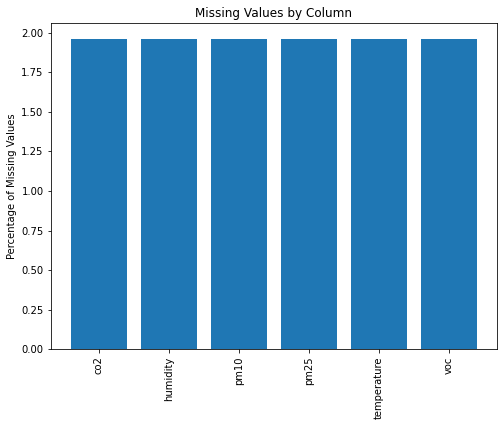

In [8]:
# Quick check: missing data.

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate percentage of missing values per column
missing_perc = 100 * data.isnull().sum() / len(data)

# Create bar plot of missing value percentages
plt.figure(figsize=(8,6))
plt.bar(missing_perc.index, missing_perc)
plt.xticks(rotation=90)
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Values by Column')
plt.show()

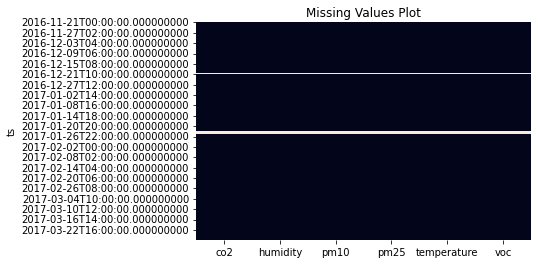

,missing_columns
row_index,
2016-12-01 05:00:00,"[pm25, pm10, humidity, temperature, voc, co2]"
2016-12-06 08:00:00,"[pm25, pm10, humidity, temperature, voc, co2]"
2016-12-06 09:00:00,"[pm25, pm10, humidity, temperature, voc, co2]"
2016-12-06 10:00:00,"[pm25, pm10, humidity, temperature, voc, co2]"
2016-12-06 11:00:00,"[pm25, pm10, humidity, temperature, voc, co2]"


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot missing values
sns.heatmap(data.isna(), cbar=False)
plt.title('Missing Values Plot')
plt.show()

# Record missing value indices for each column
missing_values = {}
for col in data.columns:
    missing_indices = data[col][data[col].isnull()].index.tolist()
    missing_values[col] = missing_indices

# Group missing values by row number
missing_rows = {}
for col, indices in missing_values.items():
    for idx in indices:
        if idx not in missing_rows:
            missing_rows[idx] = {col}
        else:
            missing_rows[idx].add(col)

# Create final dataframe with missing values and their row indices
missing_df = pd.DataFrame(columns=['row_index', 'missing_columns'])
for idx, cols in missing_rows.items():
    missing_df.loc[len(missing_df)] = [idx, list(cols)]
missing_df.set_index('row_index', inplace=True)

missing_df.head()


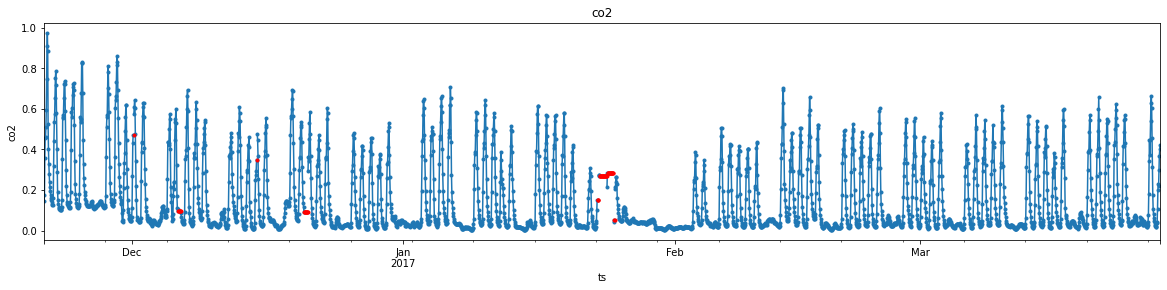

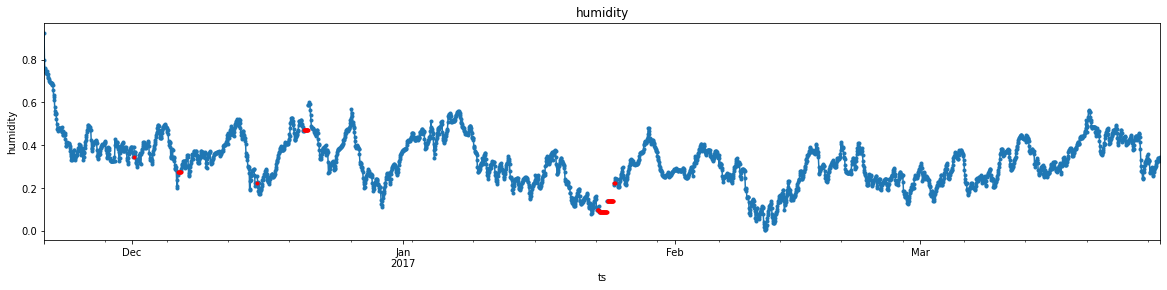

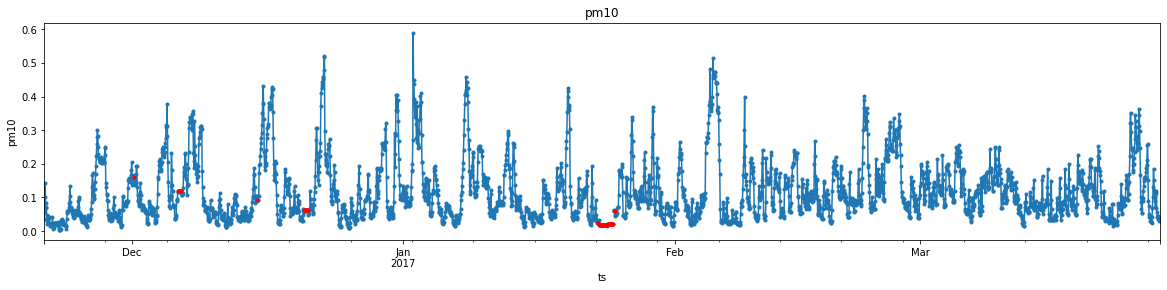

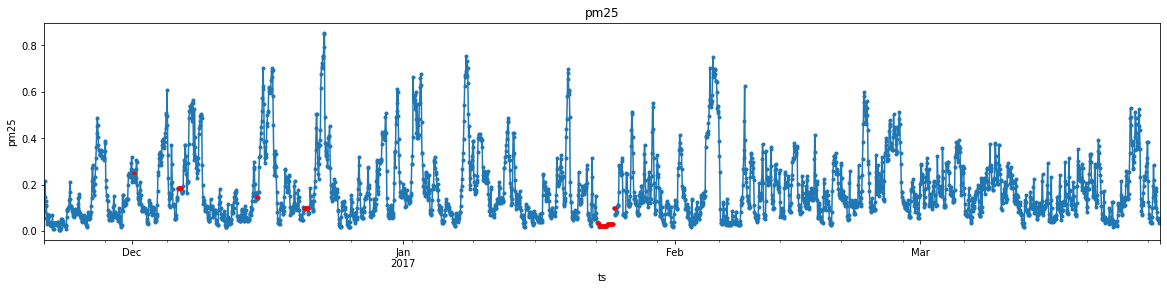

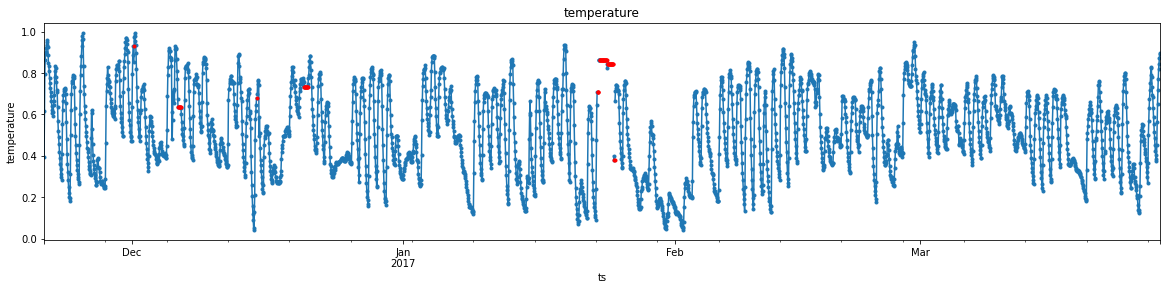

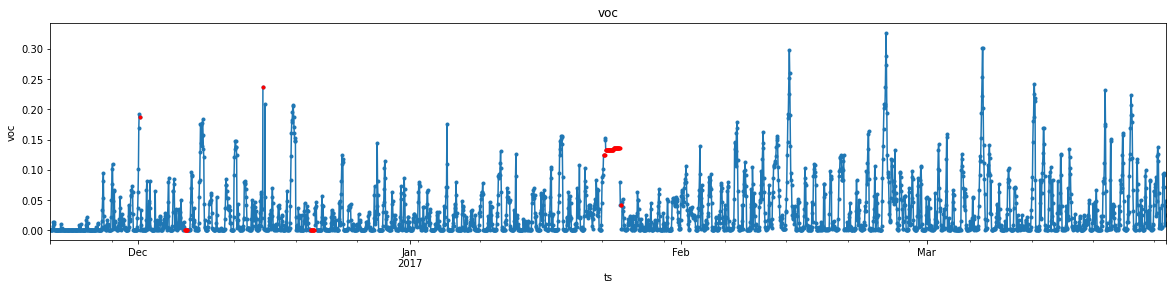

In [9]:
# Introduce the missing timestamps.
# Note that we capture this in a different dataframe.
data_ = data.asfreq("1H")

# Apply the forward fill method.
data_imputed = data_.fillna(method="ffill")

# Plot the imputed time series.
for var in data.columns:

    # plot the time series.
    ax = data_[var].plot(linestyle="-", marker=".", figsize=[20, 4])

    # plot the imputed values on top, in red.
    data_imputed[data_.isnull()][var].plot(ax=ax, legend=None, marker=".", color="r")

    # Add title.
    plt.title(var)

    # the y axis label
    plt.ylabel(var)

    plt.show()

In [11]:
data_imputed.isnull().sum()

co2            60
humidity       60
pm10           60
pm25           60
temperature    60
voc            60
dtype: int64

plot time series

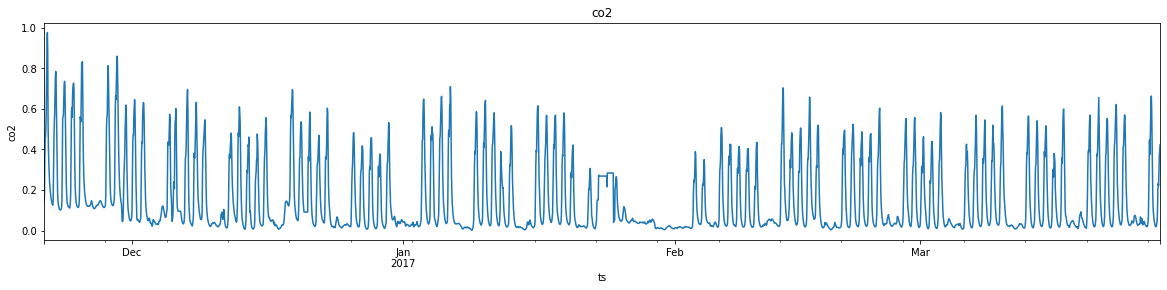

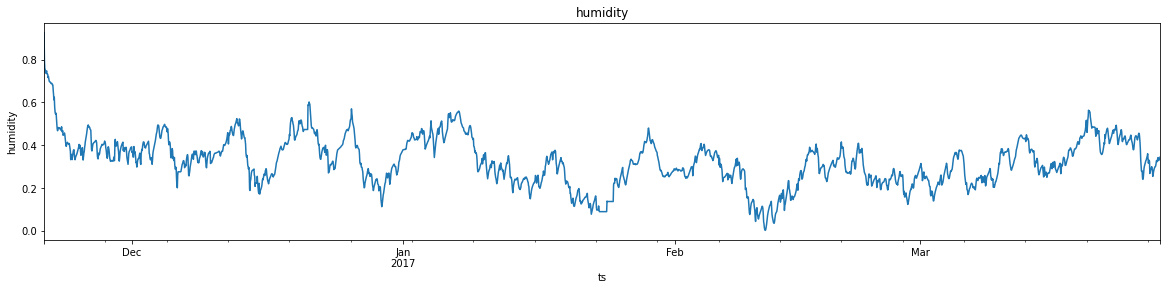

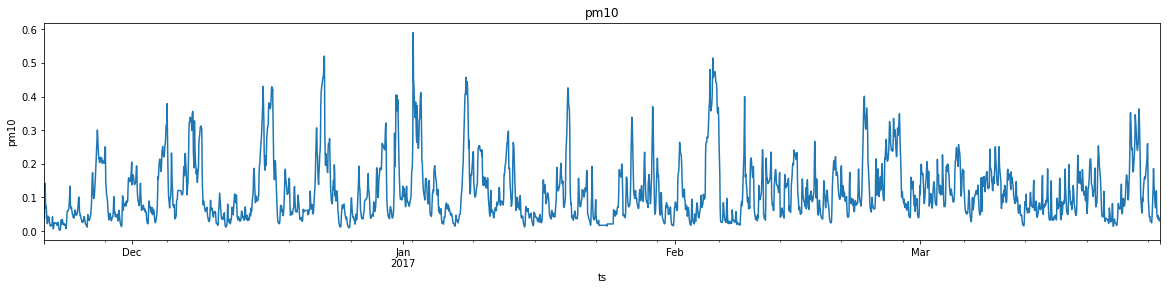

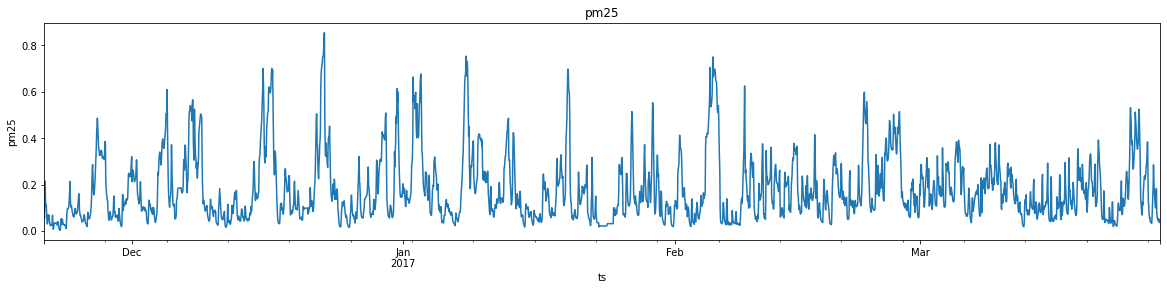

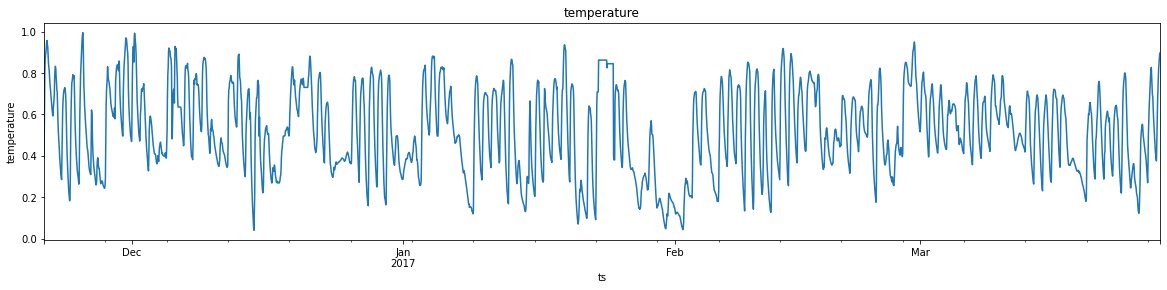

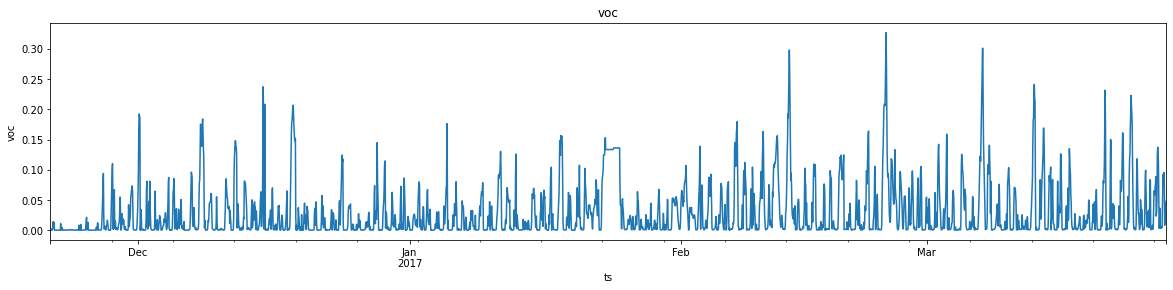

In [13]:
# Plot the time series after data imputation.
pollutants=data.columns
for var in pollutants:

    # Plot the time series
    data_imputed[var].plot(figsize=(20, 4))

    # Add title
    plt.title(var)

    # the y axis label
    plt.ylabel(var)

    plt.show()

## Seasonality

Indoor Air pollutant concentration changes with car traffic. Lets check how they vary during the hours in a day.

In [15]:
# Capture "time" in a new variable.
data=data_imputed
time_ = data.index.time

time_ = pd.Series(time_, index=data.index)

time_.head()

ts
2016-11-21 00:00:00    00:00:00
2016-11-21 01:00:00    01:00:00
2016-11-21 02:00:00    02:00:00
2016-11-21 03:00:00    03:00:00
2016-11-21 04:00:00    04:00:00
Freq: H, dtype: object

In [16]:
pollutants

Index(['co2', 'humidity', 'pm10', 'pm25', 'temperature', 'voc'], dtype='object')

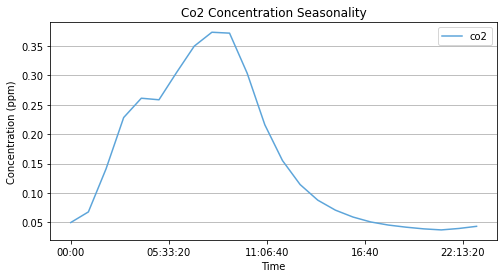

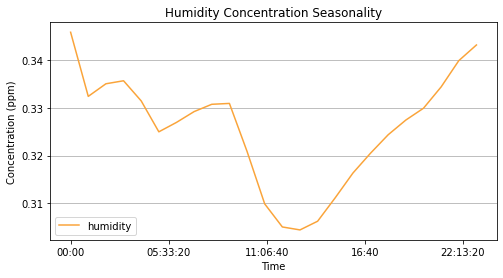

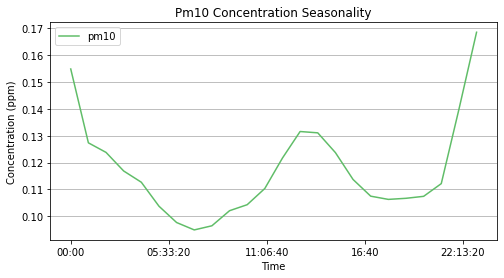

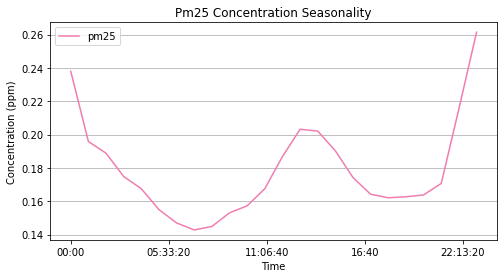

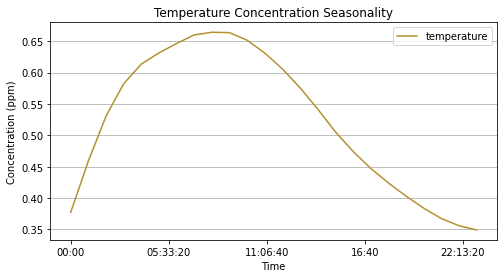

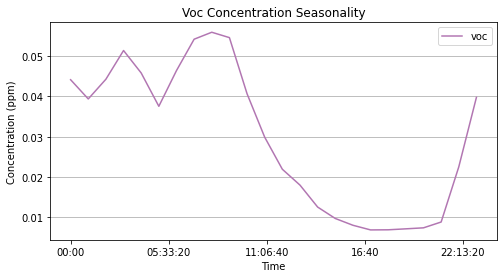

In [17]:
# Plot the average pollutant concentration per hour.

import matplotlib.pyplot as plt

# Use a custom color scheme with muted colors
colors = {'co2': '#5DA5DA',
          'humidity': '#FAA43A',
          'pm10': '#60BD68',
          'pm25': '#F17CB0',
          'temperature': '#B2912F',
          'voc': '#B276B2'}

for variable in pollutants:
    # Apply the groupby operation and plot the mean concentration for each variable for daily frequency
    fig, ax = plt.subplots(figsize=(8, 4))
    data.groupby(time_)[[variable]].mean().plot(ax=ax, color=colors[variable])
    ax.set_title(f"{variable.capitalize()} Concentration Seasonality")
    ax.set_ylabel("Concentration (ppm)")
    ax.set_xlabel("Time")
    ax.grid(axis='y') # Add grid lines to the y-axis
    
    # Save the figure as a high-quality PDF file
    fig.savefig(f"./Plots/{variable}_seasonality.pdf", dpi=300, bbox_inches='tight')
    
    plt.show() # Show the plot

